In [440]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [2]:
def Properties(SpecHeat,dTad,B_l_int,B_h_int,T,N_ml): #Get the properties on the low and high field

    C_l = zeros([N_ml,len(T)])
    C_h = zeros([N_ml,len(T)])
    dT_l = zeros([N_ml,len(T)])
    dT_h = zeros([N_ml,len(T)])
    

    for i in range(K):
        if B_exp[i] == B_l_int:
            for j in range(N_ml):
                C_l[j][i]=C[j,i]
                dT_l[j][i]=dT[j,i]

        if B_exp[i] == B_h_int and B_exp[i-1]< B_h_int:
            A = i
        if B_exp[i] == B_h_int:
            for j in range(N_ml):
                C_h[j][i-A]=C[j,i]
                dT_h[j][i-A]=dT[j,i]
                
    return(C_l,C_h,dT_l,dT_h)

In [3]:
def SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d):

    Th = 312
    Tc = 282

    C_mag = []
    C_dmag = []
    dT_mag = []
    dT_dmag = []

    T_int = np.arange(Tc,Th+0.01,0.1)


    #T_layer = np.arange(282,310.1,30/(15))
    #L_layer = (100/len(T_layer))*ones(len(T_layer))
    N_l = len(T_layer)

    A = np.int((Tc - min(T_exp))/0.1)



    T_t = []
    L = 0

    for i in range(N_l):
        L = L + L_layer[i]
        T_tr = Tc + 0.001 +L/100*(Th-Tc)
        T_t.append(T_tr)

    k = 0    
    for i in range (len(T_int)):
        #print(T_int[i])
        if T_int[i] <=T_t[k]:
            #print(T_int[i],T_t[k])
            for j in range(len(T_l)):
                #print(T_layer[k],T_l[j])
                if T_layer[k] >= T_l[j] and T_layer[k] < T_l[j+1]:
                    #print('Hello')
                    #print(T_int[i],T_t[k],T_layer[k],T_l[j],T_l[j+1])
                    C_mag.append(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j+1][int(i+A)]-(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j+1][int(i+A)]-(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j+1][int(i+A)]-(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
        else:
            for j in range(len(T_l)):
                if T_layer[k+1] >= T_l[j] and T_layer[k+1] < T_l[j+1]:
                    C_mag.append(C_h[j][int(i+A)]+(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j][int(i+A)]+(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j][int(i+A)]+(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j][int(i+A)]+(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],T_l[j+1],T_l[j],T_layer[k],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
            k = k + 1
            
    return (C_mag,C_dmag,dT_mag,dT_dmag)

In [4]:
def Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int):
    C_mag_mean   = integrate.simps(C_mag,T_int)/(max(T_int)-min(T_int))
    C_dmag_mean  = integrate.simps(C_dmag,T_int)/(max(T_int)-min(T_int))
    
    dT_mag_mean  = integrate.simps(dT_mag,T_int)/(max(T_int)-min(T_int))
    dT_dmag_mean = integrate.simps(dT_dmag,T_int)/(max(T_int)-min(T_int))
    
    CdT_mag_mean   = integrate.simps(np.array(C_mag)*np.array(dT_mag),T_int)/(max(T_int)-min(T_int))
    CdT_dmag_mean  = integrate.simps(np.array(C_dmag)*np.array(dT_dmag),T_int)/(max(T_int)-min(T_int))
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

In [5]:
def Metrics (SpecHeat,dTad,B_l_int,B_h_int,T_arg,N_ml,Th,Tc,T_l,T_layer,L_layer):
    (C_l,C_h,dT_l,dT_h) = Properties(SpecHeat,dTad,B_l_int,B_h_int,T_arg,N_ml) #Properties of low and high fields
    dT_ad = np.array(dT_h)-np.array(dT_l)
             
    T_dem = zeros([N_ml,len(T_arg)])
    for j in range(N_ml):
        T_dem[j] = T_arg + dT_ad[j]
             
    dT_ad_d = np.zeros([N_ml,len(T_arg)])
    for i in range(N_ml):
        for j in range(len(T_arg)):
            for k in range(len(T_dem[i])):
                if  T_arg[j] > T_dem[i][k] and T_arg[j] <= T_dem[i][k+1]:
                    dT_ad_d[i][j] = (dT_ad[i][k] + (T_arg[j] - T_dem[i][k])*(dT_ad[i][k+1]-dT_ad[i][k])/(T_arg[k+1]-T_arg[k]))

    (C_mag,C_dmag,dT_mag,dT_dmag) = SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d)
    
    T_int = np.arange(Tc,Th+0.01,0.1)
    
    C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean = Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int)
    
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

HEx inputs

In [287]:
def fan(V,a,b,c):
    P = a*V**2+b*V + c
    return P

In [618]:
def HEx(Xl,Xt,N_r,N_l,L1,Di,De,pf,xf,sigmaf,sigmah,pd,m_f):
    
    #Geometric definition
    #Xt = 0.0381
    #Xl = 0.033
    
    #N_r = 3
    L2 = N_r*Xl
    
    L1 = 0.32*1.5
    L3 = Xl*N_l
    
    #L2 = 0.033*4 #0.0215 #0.043
      #0.125 #0.152

    #Di = 0.01588 #694
    #De = 0.0163 #794


    
    #pf = 1/Beta
    #Nfin =100
    #Beta = Nfin/L1   #Fin density [1/m]
    
    #pf = 5*10**-3
    Beta = 1/pf
    Nfin = Beta*L1
    
    #xf = 0.007
    
    #sigmaf = 0.00015
    #sigmah = 0.0016
    
    #pd = 0.0018
    
    
    
    #Properties of air at 25ºC
    
    rho_a = 1.168      #[kg/m3] Density
    mu_a  = 0.00001849 #[kg/(m.s)] Viscosity
    cp_a  = 1004      #[kJ/kg.K] Specific heat
    Pr_a  = 0.7281     #[-] Prandtl number
    
    #Properties of the wall
    
    k_w = 273 #[W/m.K] Thermal conductivity of the aluminum
    
    #Properties of the water
    
    rho_w = 997        #[kg/m3] Density (25ºC)
    cp_w  = 4181       #[kJ/kg.K] Specific heat
    mu_wc = 0.001138   #[kg/(m.s)] Viscosity in the cold line (15ºC)
    mu_wh = 0.0007193  #[kg/(m.s)] Viscosity in the hot line (35ºC)
    Pr_wc = 8.092      #[-] Prandtl number in the cold line (15ºC)
    Pr_wh = 4.835      #[-] Prandtl number in the hot line  (35ºC)
    k_wc = 0.5888      #[-] Thermal conductivity in the cold line (15ºC)
    k_wh = 0.6217      #[-] Thermal conductivity in the hot line (35ºC)
    
    #Geometric calculation
    
    
    # Arranjo == 0 - Inline arrangement
    # Arranjo == 1 - Staggered Arrangement - Numero impar de fileiras - Última fila com o mesmo numero de tubos que a primeira
    # Arranjo == 2 - Staggered Arrangement - Numero par de fileiras   - Última fila com um tubo a menos que a primeira
    
    
    
    if N_r%2 == 0:
        arranjo = 2
    else:
        arranjo = 1
    
       
    if arranjo == 0:
        N_t = L2*L3/(Xt*Xl)
    elif arranjo == 1:
        N_t = (L3/Xt)*(L2/Xt+1)/2 + (L3/Xt-1)*(L2/Xt-1)/2
    elif arranjo == 2:
        N_t = 0.5*(L2/Xl)*(2*L3/Xt-1)
        
    
    dc = De + 2*sigmaf
    
    theta = np.arctan(pd/xf)


    
    
    if arranjo  == 0:
        A_min_o = ((Xt-De)*L1 - (Xt-De)*sigmaf*Beta*L1)*L3/Xt #Minimum free flow area
    else:
        a = ((Xt - De) - (Xt - De)*sigmaf*Beta)/2
        b = ((Xt/2)**2+Xl**2)**0.5 - De - (Xt-De)*sigmaf*Beta
        if a<b:
            c = 2*a
        else:
            c = 2*b
        A_min_o = ((L3/Xt-1)*c + (Xt-De)-(Xt-De)*sigmaf*Beta)*L1 #Minimum free flow area
    
    
    A_fr = L1*L3 #Frontal area
    sigma = A_min_o/A_fr
    
    
    A_p = np.pi*De*(L1-sigmaf*Beta*L1)*N_t+2*(L2*L3 - np.pi*De**2*N_t/4) #Primary surface area  - exposed tubes and header plates
    A_f = 2*(L2*L3-(np.pi*De**2/4)*N_t)*Beta*L1 + 2*L3*sigmaf*Beta*L1     #Secondary surface are - fin surface
    A_s = A_p + A_f       #Total heat transfer area
    A_t = np.pi*De*L1*N_t #External tube area
    
    sigma_o = (L3*L1 - L3*sigmaf*Beta*L1)/(L3*L1) #area concentration/expansion ratio
    D_h = 4*A_min_o*L2/A_s #Hydraulic diameter
    #print(D_h*1000,Beta,pf*1000)
    #Correlation parameters
    
    c1 = -0.1707 - 1.374*((Xl/sigmaf)**(-0.493))*((pf/dc)**(-0.886))*((N_r)**(-0.143))*((pd/xf)**(-0.0296))
    c2 = 0.1714 - 0.07372*((pf/Xl)**0.25)*(np.log(A_s/A_t))*((pd/xf)**(-0.2))
    c3 = 0.426*((pf/Xt)**0.3)*(np.log(A_s/A_t))
    VFR = np.arange(10,2500,1)
    dP_o = np.zeros(len(VFR))
    Rt_o = np.zeros(len(VFR))
    Re = np.zeros(len(VFR)) 
    for i in range(len(VFR)):
        vazao = VFR[i]*0.00047194745
        
        u_air = vazao/(L1*L3)
        u_max = u_air/sigma
        
        Re[i] = u_max*rho_a*dc/(mu_a)

        
        c4 = -10.2192/np.log(Re[i])
        
        
        #Pressure drop correlation
        f_o  = 0.05273*(Re[i]**c2)*((pd/xf)**c3)*((pf/Xt)**c4)*((np.log(A_s/A_t))**(-2.726))*(D_h/dc)**0.1325*((N_r)**-0.02305)
        
        G_o = rho_a*u_max
        
        dP_o[i] = G_o**2/(2*rho_a)*((f_o)*(A_s/A_min_o))
        #Coulburn factor
        
        j_o = 1.7910*((Re[i])**c1)*((Xl/sigmaf)**(-0.456))*((N_r)**(-0.27))*((pf/dc)**(-1.343))*((pd/xf)**0.317)
        h_o = j_o*rho_a*u_max*cp_a*Pr_a**(-0.66666)
        
        #Fin efficiency
        
        m = ((2*h_o)/(k_w*sigmaf))**0.5
        
        Pm = Xt/2
        Pl = (((Xt/2)**2+Xl**2)**0.5)/2
        R_eq = 1.27*Pm*(Pl/Pm-0.3)**0.5
        phi = (R_eq/(Di/2)-1)*(1+0.35*np.log(R_eq/(Di/2)))
        eta = math.tanh(m*(Di/2)*phi)/(m*(Di/2)*phi)
        eta_o = 1 - (A_f/A_s)*(1-eta)
        
        Rt_o[i] = 1/(eta_o*h_o*A_s)
           
    #Internal flow
    
    Lh=(L1+2*sigmah)*N_t
    A_i = np.pi*Di*L1*N_t
    A_min_i = np.pi*(Di**2)/4
    G_i = m_f/A_min_i
    
    Re_ic = G_i*Di/mu_wc 
    Re_ih = G_i*Di/mu_wh
    
    A_c = (2.457*np.log(1/((7/Re_ic)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_c = (37530/Re_ic)**16
    
    A_h = (2.457*np.log(1/((7/Re_ih)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_h = (37530/Re_ih)**16
    
    f_c = (8*((8/Re_ic)**12 + (A_c + B_c)**(-3/2))**(1/12))/4
    f_h = (8*((8/Re_ih)**12 + (A_h + B_h)**(-3/2))**(1/12))/4
    
    if Re_ih < 2300:
        Nu_ih = 3.66
    else:
        Nu_ih = ((f_h/2)*(Re_ih-1000)*Pr_wh)/(1+12.7*((f_h/2)**0.5)*(Pr_wh**(2/3)-1))
                                              
    if Re_ic < 2300:
        Nu_ic = 3.66
    else:
        Nu_ic = ((f_c/2)*(Re_ic-1000)*Pr_wc)/(1+12.7*((f_c/2)**0.5)*(Pr_wc**(2/3)-1))   
    
    h_i_c = Nu_ic*k_wc/Di
    h_i_h = Nu_ih*k_wh/Di
           
    Rt_i_c = 1/(h_i_c*A_i)
    Rt_i_h = 1/(h_i_h*A_i)
    
    
    dP_i_c = f_c*G_i**2*4*Lh/(2*rho_w*Di)
    dP_i_h = f_h*G_i**2*4*Lh/(2*rho_w*Di)
                                              
    W_p_c = dP_i_c*m_f/rho_w
    W_p_h = dP_i_h*m_f/rho_w
    
    
    #Performance metrics
    
    UA_h = (Rt_o+Rt_i_h)**-1
    UA_c = (Rt_o+Rt_i_c)**-1
    
    W_o = VFR*0.00047194745*dP_o/0.1
    
    NTU_c = UA_c/(VFR*0.00047194745*rho_a*cp_a)
    NTU_h = UA_h/(VFR*0.00047194745*rho_a*cp_a)
    
    C_r = (VFR*0.00047194745*rho_a*cp_a)/(m_f*cp_w)
    
    if N_r == 1:
        Eff_h = (1-np.exp(-C_r*(1-np.exp(-NTU_h))))/C_r
        Eff_c = (1-np.exp(-C_r*(1-np.exp(-NTU_c))))/C_r
    elif N_r == 2:
        K = (1-np.exp(-NTU_h/2))
        Eff_h = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
        K = (1-np.exp(-NTU_c/2))
        Eff_c = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
    elif N_r == 3:
        K = (1-np.exp(-NTU_h/3))
        Eff_h = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
        K = (1-np.exp(-NTU_c/3))
        Eff_c = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
    elif N_r ==4:
        K = (1-np.exp(-NTU_h/4))
        Eff_h = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
        K = (1-np.exp(-NTU_c/4))
        Eff_c = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
    else:
        Eff_h = 1 - np.exp(NTU_h**0.22*(np.exp(-C_r*NTU_h**0.78)-1)/C_r)
        Eff_c = 1 - np.exp(NTU_c**0.22*(np.exp(-C_r*NTU_c**0.78)-1)/C_r)
    
    ECr_c = Eff_c*C_r
    ECr_h = Eff_h*C_r
    
    #Fan
    
    #https://www.ebmpapst.com/en/products/axial-fans/axialfansdetail.php?pID=139216
    
    dP_v = np.array([37,35,30,22,11,0])
    V  = np.array([1000,1250,1500,1750,2000,2250])*0.588578
    
    #dP_v = np.array([0,7,20,32,40,47,54])
    #V = np.array([2900,2750,2500,2250,2000,1750,1500])*0.588578
    
    Coef_fan = curve_fit(fan,V,dP_v,maxfev=1000)
    
    aux = fan(VFR,Coef_fan[0][0],Coef_fan[0][1],Coef_fan[0][2])-dP_o
    Inter = np.abs(aux).argmin() 

    return(W_o[Inter],ECr_c[Inter],ECr_h[Inter],Re[Inter],dP_o[Inter],W_p_c,W_p_h)

In [378]:
#p_f = np.arange(6.87*10**-3,8.25*10**-3,(8.25-6.87)*10**-4)
A = 27.5*10**-3
B = 33*10**-3
N_r = np.arange(A,B*1.01,(B-A)/10)
#N_r = np.arange(0.5,1.1,0.1)
N_r

array([0.0275 , 0.02805, 0.0286 , 0.02915, 0.0297 , 0.03025, 0.0308 ,
       0.03135, 0.0319 , 0.03245, 0.033  ])

In [379]:
Xt = 0.0381
Xl = 0.033
N_r = 3
N_l = 10
L1 = 0.5
Di = 0.01588 
De = 0.0163 
pf = 5*10**-3
xf = 0.007

    
m_f = 2500/3600
HEx(Xl,Xt,N_r,N_l,L1,Di,De,pf,xf,sigmaf,sigmah,pd,m_f)

(119.22707854769075,
 0.08186825644640272,
 0.08246471221999307,
 5302.737597572413,
 26.818245110971034)

In [380]:
Xt = np.arange(31.75*10**-3,1.01*38.1*10**-3,(38.1*10**3-31.75*10**-3)/5)

In [381]:
Xt = np.array(38.1*10**-3)


In [452]:
Xt = 0.0381
Xl = 0.033
N_r = 3
N_l = 10
L1 = 0.5
Di = 0.01588 
De = 0.0163 
pf = 5*10**-3
xf = 0.007

In [470]:
Y

array([0.03175   , 0.02540362, 0.01905723, 0.01271085, 0.00636446])

In [477]:
m_f = 3000/3600
a = 2.98*10**-3
b = 6.43*10**-3
Y = np.arange(a,1.01*b,(b-a)/5)

W_fan= np.zeros(len(Y))
Effec = np.zeros(len(Y))
for i in range(len(Y)):
    A,B,C,D,E,F,G = HEx(Xl,Xt,N_r,N_l,L1,Di,De,Y[i],xf,sigmaf,sigmah,pd,m_f)
    W_fan[i] = A
    Effec[i] = B
    

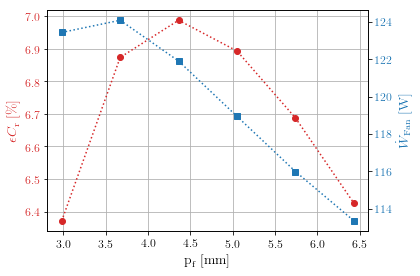

In [479]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('p$_\mathrm{f}$ [mm]', fontsize = '14')
ax1.set_ylabel('$\epsilon C_\mathrm{r}$ [$\%$]', color=color, fontsize = '14')
ax1.plot(Y*1000, Effec*100,'o:', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('$\dot{W}_\mathrm{Fan}$ [W]', color=color,fontsize = '14')  # we already handled the x-label with ax1
ax2.plot(Y*1000, W_fan,'s:', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('pf_operation.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

In [1082]:
sigmaf = 0.00015
sigmah = 0.0016
pd = 0.0018

Di = 0.01588 
De = 0.0163 

m_f = np.arange(2000/3600,4100/3600,400/3600)
Xt = np.arange(31.75*10**-3,1.01*38.1*10**-3,(38.1*10**-3-31.75*10**-3)/3)
Xt = np.array(38.1*10**-3)
Xl = np.arange(27.5*10**-3,1.01*33*10**-3,(33*10**-3-27.5*10**-3)/3)
Xl = 33*10**-3
pf = np.arange(2.98/2*10**-3,1.01*6.43*10**-3,(6.43*10**-3-2.98/2*10**-3)/6)
N_r = np.arange(1,4.1,1)
N_l = np.arange(15,46,3)
L1  = np.arange(0.5,1.51,0.1)
xf = np.arange(6.87*10**-3,1.01*8.25*10**-3,(8.25*10**-3-6.87*10**-3)/3)
xf = 7*10**-3

W = np.zeros([size(m_f),size(Xl),size(Xt),len(N_r),len(N_l),len(L1),len(pf),size(xf)])
W_p_h = np.zeros([size(m_f),size(Xl),size(Xt),len(N_r),len(N_l),len(L1),len(pf),size(xf)])
W_p_c = np.zeros([size(m_f),size(Xl),size(Xt),len(N_r),len(N_l),len(L1),len(pf),size(xf)])
ECr_c = np.zeros([size(m_f),size(Xl),size(Xt),len(N_r),len(N_l),len(L1),len(pf),size(xf)])
ECr_h = np.zeros([size(m_f),size(Xl),size(Xt),len(N_r),len(N_l),len(L1),len(pf),size(xf)])
print(size(W))


w = 0
for p in range(len(m_f)):
    for i in range(size(Xl)):
        for j in range(size(Xt)):
            for k in range(len(N_r)):
                for l in range(len(N_l)):
                    for m in range(len(L1)):
                        for n in range(len(pf)):
                            for o in range(size(xf)):
                                A,B,C,D,E,F,G = HEx(Xl,Xt,N_r[k],N_l[l],L1[m],Di,De,pf[n],xf,sigmaf,sigmah,pd,m_f[p])
                                W[p][i][j][k][l][m][n][o] = A
                                ECr_c[p][i][j][k][l][m][n][o] = B
                                ECr_h[p][i][j][k][l][m][n][o] = C
                                W_p_h[p][i][j][k][l][m][n][o] = F
                                W_p_c[p][i][j][k][l][m][n][o] = G
                                #print(F,G)
                                w = w+1
                                print(w)

20328
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344


6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985


8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627


10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
1022

11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
1159

12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
1296

14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
1432

15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
1569

16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
1706

18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
1843

19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
1979

In [1083]:
W_array_L = np.zeros([size(m_f),np.int(size(W)/size(m_f))])
Ec_array_L = np.zeros([size(m_f),np.int(size(W)/size(m_f))])
Eh_array_L = np.zeros([size(m_f),np.int(size(W)/size(m_f))])
W_p_h_array_L = np.zeros([size(m_f),np.int(size(W)/size(m_f))])
W_p_c_array_L = np.zeros([size(m_f),np.int(size(W)/size(m_f))])

In [1084]:
w = 0
for p in range(size(m_f)):
    for i in range(size(Xl)):
        for j in range(size(Xt)):
            for k in range(len(N_r)):
                for l in range(len(N_l)):
                    for m in range(len(L1)):
                        for n in range(len(pf)):
                            for o in range(size(xf)):
                                W_array_L[p][w-p*np.int(size(W)/size(m_f))] = W[p][i][j][k][l][m][n][o]
                                Ec_array_L[p][w-p*np.int(size(W)/size(m_f))] = ECr_c[p][i][j][k][l][m][n][o]
                                Eh_array_L[p][w-p*np.int(size(W)/size(m_f))] = ECr_h[p][i][j][k][l][m][n][o]
                                W_p_h_array_L[p][w-p*np.int(size(W)/size(m_f))] = W_p_h[p][i][j][k][l][m][n][o]
                                W_p_c_array_L[p][w-p*np.int(size(W)/size(m_f))] = W_p_c[p][i][j][k][l][m][n][o]
                                w = w+1
                                print(w)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322


6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447


8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221


10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
1018

12021
12022
12023
12024
12025
12026
12027
12028
12029
12030
12031
12032
12033
12034
12035
12036
12037
12038
12039
12040
12041
12042
12043
12044
12045
12046
12047
12048
12049
12050
12051
12052
12053
12054
12055
12056
12057
12058
12059
12060
12061
12062
12063
12064
12065
12066
12067
12068
12069
12070
12071
12072
12073
12074
12075
12076
12077
12078
12079
12080
12081
12082
12083
12084
12085
12086
12087
12088
12089
12090
12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
12118
12119
12120
12121
12122
12123
12124
12125
12126
12127
12128
12129
12130
12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154
12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166
12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
12182
12183
12184
12185
12186
1218

14020
14021
14022
14023
14024
14025
14026
14027
14028
14029
14030
14031
14032
14033
14034
14035
14036
14037
14038
14039
14040
14041
14042
14043
14044
14045
14046
14047
14048
14049
14050
14051
14052
14053
14054
14055
14056
14057
14058
14059
14060
14061
14062
14063
14064
14065
14066
14067
14068
14069
14070
14071
14072
14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
14089
14090
14091
14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109
14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
14122
14123
14124
14125
14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138
14139
14140
14141
14142
14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
1418

16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
1618

18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
18033
18034
18035
18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047
18048
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058
18059
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
18145
18146
18147
18148
18149
18150
18151
18152
18153
18154
18155
18156
18157
18158
18159
18160
18161
18162
18163
18164
18165
18166
18167
18168
18169
18170
18171
18172
18173
18174
18175
18176
18177
18178
18179
18180
18181
18182
18183
18184
1818

20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
20075
20076
20077
20078
20079
20080
20081
20082
20083
20084
20085
20086
20087
20088
20089
20090
20091
20092
20093
20094
20095
20096
20097
20098
20099
20100
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116
20117
20118
20119
20120
20121
20122
20123
20124
20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140
20141
20142
20143
20144
20145
20146
20147
20148
20149
20150
20151
20152
20153
20154
20155
20156
20157
20158
20159
20160
20161
20162
20163
20164
20165
20166
20167
20168
20169
20170
20171
20172
20173
20174
20175
20176
20177
20178
20179
20180
20181
20182
20183
20184
2018

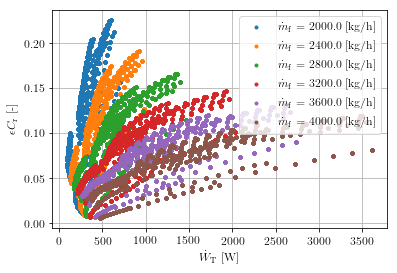

In [1085]:
W_t_L = 2*W_array_L+W_p_h_array_L/0.9+W_p_c_array_L/0.9
for i in range(size(m_f)):
    plt.plot(W_t_L[i],Ec_array_L[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h]')
#plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')

plt.show()

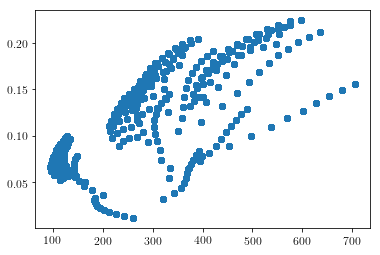

In [1086]:
plt.plot(W_t_L[0],Ec_array_L[0],'o')

In [1087]:


#Ec_final = concatenate((Ec_array,Ec_array_L))

#W_final = concatenate((W_t,W_t_L))

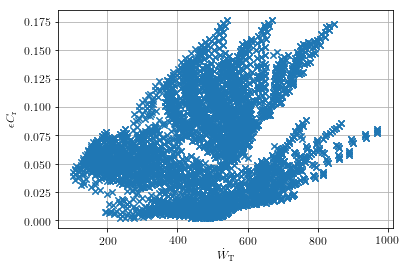

In [1088]:
#W_t_L = 2*W_array_L+W_p_h_array_L/0.9+W_p_c_array_L/0.9
plt.plot(W_final,Ec_final,'x')
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$')
plt.ylabel('$\epsilon C_\mathrm{r}$')
plt.show()

In [1101]:
Ec_p_F = [[] for i in range(len(m_f))]
W_p_F = [[] for i in range(len(m_f))]

Ec_p_T = []
W_p_T =[]
m_f_T = []

for k in range(size(m_f)):
    for i in range(len(Ec_array_L[k])):
        A = 0
        for j in  range(len(Ec_array_L[k])):
            if Ec_array_L[k][i] < Ec_array_L[k][j] and W_t_L[k][i] > W_t_L[k][j]:
                #print(i,j)
                A = 1
                #break
        if A == 0 :
            Ec_p_F[k].append(Ec_array_L[k][i])
            W_p_F[k].append(W_t_L[k][i])
            if Ec_array_L[k][i]>0.04 and W_t_L[k][i] < 500 :
                Ec_p_T.append(Ec_array_L[k][i])
                W_p_T.append(W_t_L[k][i])
                m_f_T.append(m_f[k])

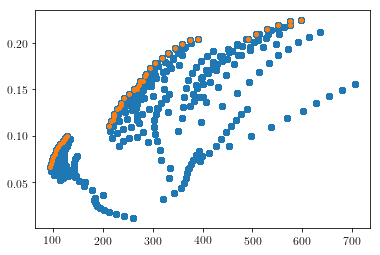

In [1090]:
plt.plot(W_t_L[0],Ec_array_L[0],'o')
plt.plot(W_p_F[0],Ec_p_F[0],'.')

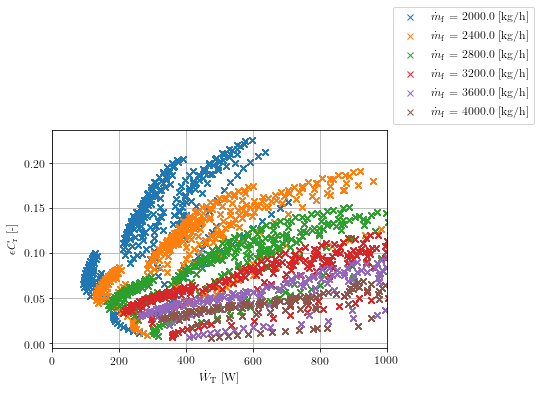

In [1125]:
#W_t_L = 2*W_array_L+W_p_h_array_L/0.9+W_p_c_array_L/0.9
for i in range(size(m_f)):
    plt.plot(W_t_L[i],Ec_array_L[i],'x', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h]')
    #plt.plot(W_p_F[i],Ec_p_F[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h]')
plt.legend(bbox_to_anchor=(1, 1))
#plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
plt.xlim([0,1000])
plt.show()

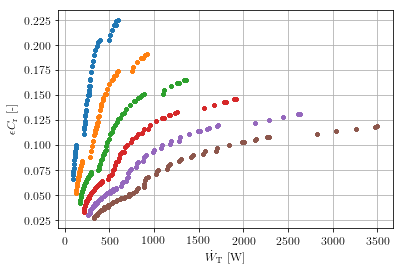

In [1103]:
for i in range(size(m_f)):
    #plt.plot(W_t_L[i],Ec_array_L[i],'s', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h]')
    plt.plot(W_p_F[i],Ec_p_F[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h]')
#plt.legend(bbox_to_anchor=(1, 1))
#plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
#plt.xlim([200,500])
plt.show()

In [1111]:
def Paretto_HEx(X,a,b,c,d,e,f):
    P1,P2= X
    return (a*P1**b*P2**c)  

In [1112]:
Paret_Hex = curve_fit(Paretto_HEx,(m_f_T,W_p_T),Ec_p_T,maxfev=1000000)
Paret_Hex

C:\Users\Usuario\Anaconda_new\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([ 6.63907766e-04, -2.51978069e+00,  7.09454422e-01,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00]),
 array([[inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf]]))

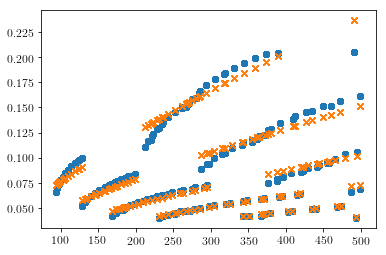

In [1113]:
plt.plot(W_p_T,Ec_p_T,'o')
plt.plot(W_p_T,Paretto_HEx((np.array(m_f_T),np.array(W_p_T)),Par
                           ,,et_Hex[0][0],Paret_Hex[0][1],Paret_Hex[0][2],Paret_Hex[0][3],Paret_Hex[0][4],Paret_Hex[0][5]),'x')

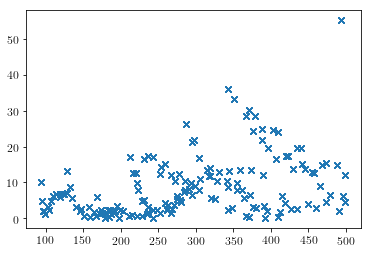

In [1107]:
Erro_HEx = abs(Ec_p_T - Paretto_HEx((np.array(m_f_T),np.array(W_p_T)),Paret_Hex[0][0],Paret_Hex[0][1],Paret_Hex[0][2],Paret_Hex[0][3],Paret_Hex[0][4],Paret_Hex[0][5]))/Ec_p_T*100
plt.plot(W_p_T,Erro_HEx,'x')

In [1004]:
plt.plot(W_array_,Ec_final,'.')
plt.plot(W_p_F,Ec_p_F,'x')

#plt.plot(W_t_L,Ec_array_L,'.')
#plt.plot(W_p_L,Ec_p_L,'x')

plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
plt.show()
plt.savefig('Fan_Both_mf_2400.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

NameError: name 'W_array_' is not defined

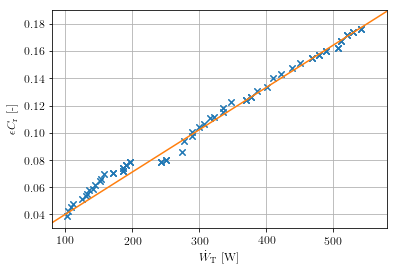

In [680]:
aux = arange(0,600,1)

plt.plot(W_p_F,Ec_p_F,'x')
plt.plot(aux,(0.14/450)*array(aux)+0.04-14/450)
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')

plt.xlim([80,580])
plt.ylim([0.03,0.19])
plt.show()
#plt.savefig('Fan_Both_mf_2400_Paretto.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

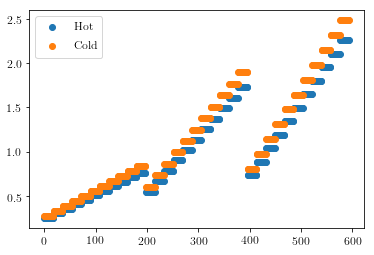

In [594]:
plt.plot(W_p_c_array/m_f/100,'o',label = 'Hot')
plt.plot(W_p_h_array/m_f/100,'o', label = 'Cold')
plt.legend()

In [233]:
W = []
Ec = []
Eh = []
Re_dc = []
dP = []

for i in range(len(N_r)):
    A = HEx(Xl,Xt,N_r[i],N_l,L1,Di,De,pf,xf,sigmaf,sigmah,pd,m_f)
    W.append(A[0])
    Ec.append(A[1])
    Eh.append(A[2])
    Re_dc.append(A[3])
    dP.append(A[4])

5.693898462958798 200.0 5.0
5.696257913842089 200.0 5.0
5.698528461412103 200.0 5.0
5.7007150375238025 200.0 5.0
5.702822215866444 200.0 5.0
5.704854243897611 200.0 5.0
5.706815071420374 200.0 5.0
5.708708376208279 200.0 5.0
5.7105375870278285 200.0 5.0
5.712305904361795 200.0 5.0
5.714016319096771 200.0 5.0


In [262]:

A[0]

fan(2250*0.588578,A[0][0],A[0][1],A[0][2])

-0.535714334967782

In [288]:
aux = fan(VFR,A[0][0],A[0][1],A[0][2])-dP[0]
inter = np.abs(aux).argmin()


1210

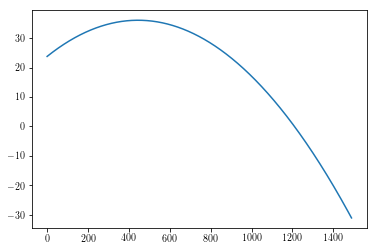

In [277]:
plt.plot(aux)

[]

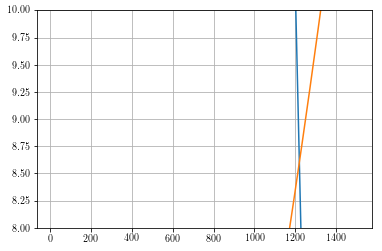

In [285]:
dP_v = np.array([37,35,30,22,11,0])
V  = np.array([1000,1250,1500,1750,2000,2250])*0.588578
A = curve_fit(fan,V,dP_v,maxfev=10000)
VFR = np.arange(10,1500,1)
plt.plot(VFR,fan(VFR,A[0][0],A[0][1],A[0][2]))
plt.plot(VFR,dP[0])
plt.ylim([8,10])
plt.grid()
plt.plot()

https://www.ebmpapst.com/en/products/axial-fans/axialfansdetail.php?pID=139216

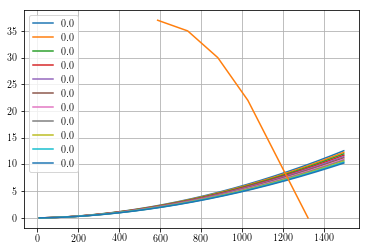

In [239]:
for i in range(len(N_r)):
    plt.plot(VFR,dP[i],label = str(round(N_r[i])))
plt.plot(V,dP_v)
plt.legend()
plt.grid()

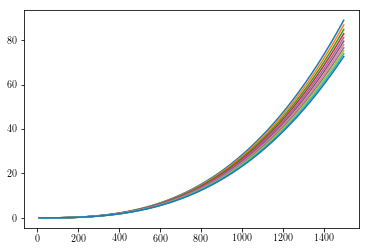

In [240]:
for i in range(len(N_r)):
    plt.plot(VFR,W[i],label = str(round(N_r[i])))
    #plt.ylim([0,50])

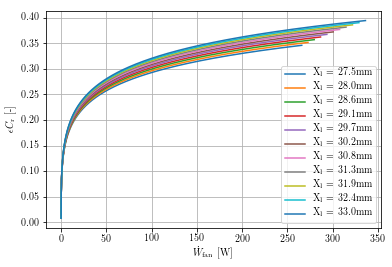

In [222]:
for i in range(len(N_r)):
    plt.plot(W[i],Ec[i],label = r'X$_\mathrm{l}$ = ' + str(round(N_r[i]*1000,1)) + 'mm')
plt.legend()
plt.xlabel('$\dot{W}_\mathrm{fan}$ [W]')
plt.ylabel('$ \epsilon C_\mathrm{r}$ [-]')
plt.grid()
#plt.savefig('X_l.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

In [11]:
Di = 0.15
m_f = 2000/3600
A_min_i = np.pi*(0.15**2)/4
G_i = m_f/A_min_i

mu_wc = 0.001138   #[kg/(m.s)] Viscosity in the cold line (15ºC)
mu_wh = 0.0007193 

Re_ic = G_i*Di/mu_wc 
Re_ih = G_i*Di/mu_wh 
Re_ic,Re_ih

(4143.850630525167, 6555.959985454802)

Constant inputs

In [12]:
##Properties of the solid 

rho_s = 7900  #[kg/m3] Density of the solid
k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

## Propertis of the fluid

rho_f = 1000  #[kg/m3] Density of the fluid
c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
Pr_f  = 6.136 #[-] Prandtl of the fluid
mu_f  = 0.0008901 #[kg/m-2] #Viscosity of the fluid
k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

## Porous medium
d_p = 500*10**(-6) #[m] Particle diameter
Epsilon = 0.45  #[-] Porosity

Properties Calculation

In [13]:
Prop = xlrd.open_workbook('La-Fe-Si.xlsx') #Import Properties File
SpecHeat = Prop.sheet_by_name('C') # #Import Specific Heat
dTad = Prop.sheet_by_name('dT') #Import Adiabatic Temperature Change

T_exp = dTad.col_values(0) #Import experimented temperatures 
B_exp = dTad.col_values(1) #Import experimented magnetic fields

T_arg = arange(min(T_exp),max(T_exp)+0.01,0.1)

K = len(dTad.col_values(0)) #Import data number

T_l = arange(270,315,2)#ture of Curie of the multilayer
N_ml = len(T_l) #Number of Multilayer Layers



dT = zeros([N_ml,K])
C = zeros([N_ml,K])
for i in range(N_ml):
    dT[i,:] = (dTad.col_values(i+2))    #Data of Adiabatic Temperature change
    C[i,:] = (SpecHeat.col_values(i+2)) #Data of specific heat

In [14]:
T_layer = arange(283,313.1,30/14)
L_layer = 100/len(T_layer)*ones(len(T_layer))

Importing AMR simulation inputs

In [15]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_c = array(Inputs.col_values(3)) #Import temperature span [K]
T_h = array(Inputs.col_values(4)) #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7)) #Import mass flow rate [kg/h]
Q_c = array(Inputs.col_values(8)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(9)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(10)) #Import Pumping power [W]
W_m = array(Inputs.col_values(11)) #Import Magnetic power [W]

Calculation

In [16]:
#Porous medium
m_s   = L*W*H*10**-9*(1-Epsilon)*rho_s #mass of the AMR
Beta = (1-Epsilon)*6/d_p
v_s   = (m_f/3600)/(rho_f*W*H*10**-6) #Superficial velocity

#Dimensionless Numbers
Re_dp = d_p*v_s*rho_f/((1-Epsilon)*mu_f) #Reynolds number
Nu = 2*(1+4*(1-Epsilon)/Epsilon)+((1-Epsilon)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
Pe = Re_dp*Pr_f

h_int = Nu*k_f/d_p

#Effective conduction
k_e_f = k_f*Epsilon #Fluid effective conduction


a_0 = exp(-1.084-6.778*(Epsilon-0.298))
f_0 = 0.8
k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

D_ = (k_f*rho_f/c_f)*0.75*Pe/2

k_s_eff = k_e_s
k_f_eff = k_e_f + rho_f*c_f*D_

In [17]:
C_H = zeros(len(L))
C_L = zeros(len(L))
dT_mg = zeros(len(L))
dT_dmg = zeros(len(L))
CdT_mg = zeros(len(L))
CdT_dmg = zeros(len(L))

In [18]:
for i in range(len(L)):
    print(i)
    C_H[i],C_L[i],dT_mg[i],dT_dmg[i],CdT_mg[i],CdT_dmg[i] = Metrics (SpecHeat,dTad,0,B[i],T_arg,N_ml,T_h[i],T_c[i],T_l,T_layer,L_layer)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Porous Medium Eff

In [19]:
NTU_f  = h_int*Beta*(L*W*H*10**(-9))/(m_f/3600*c_f) 
#NTU_HB = h_int*Beta*(L*W*H*10**(-9))/(m_s*C_H*f)
#NTU_CB = h_int*Beta*(L*W*H*10**(-9))/(m_s*C_L*f)

Eff = Data.sheet_by_name('Eff') 

Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)

Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

Model Parameters - Similarity

In [20]:
Pi_1 = k_s_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_2 = Epsilon/(1-Epsilon)*k_f_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_3 = W_p/(m_s*f*CdT_dmg)
Pi_4 = CdT_mg/CdT_dmg
Pi_5 = h_int*Beta/(f*rho_s*CdT_dmg) #dT_sf unknown
Pi_6 = ((m_f/3600)*c_f)/(m_s*C_L*f)
Pi_7 = (T_h-T_c)/(dT_dmg)

Pi_8 = Q_c/(m_s*f*CdT_dmg)
Pi_9 = Q_h/(m_s*f*CdT_dmg)
Pi_10 = W_m/(m_s*f*CdT_dmg)

Efness_HB = zeros(len(Pi_6))
Efness_CB = zeros(len(Pi_6))

for i in range(len(Pi_6)):
    Efness_HB[i] = Effectiv(Pi_6[i]/2,NTU_f[i])
    Efness_CB[i] = Effectiv(Pi_6[i]/(2*Pi_4[i]),NTU_f[i])

Model Parameters - Integral

In [21]:
Q_pas_CB = Efness_CB*(T_h - T_c)*m_f*c_f
Q_act_CB = dT_mg*m_f*c_f
Q_span = (T_h - T_c)*m_f*c_f
Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(T_h-T_c)/L
W_mag  = m_s*f*(CdT_mg - CdT_dmg)

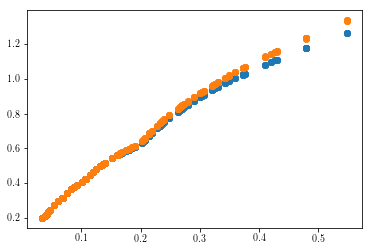

In [22]:
plt.plot(Pi_6,30*(1-Efness_HB),'o')
plt.plot(Pi_6,30*(1-Efness_CB),'o')

In [23]:
def fitting(X,a,b,c,d): 
    P1,P2= X
    return ((a*(P1**b)+c*(P1*P2)**(d)))

In [24]:
def fitting_W(X,a,b,c,d,e): 
    P1,P2= X
    return ((a*(P1**b)*P2**c)+d*(P1*P2)**e)

In [25]:
def fit_int(X,a,b,c,d,e,f,g,h): 
    P1,P2,P3,P4,P5,P6,P7= X
    return (a*(P1**b)*(P2**0)*(P3**0)*(P4**0)*(P5**0)*(P6**0)*(P7**0))

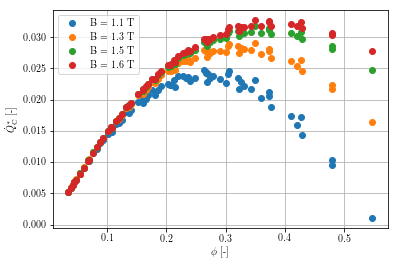

In [26]:
plt.plot(Pi_6[0:72],Pi_8[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_8[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_8[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_8[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{Q}_\mathrm{C}^*$ [-]')
plt.legend()
plt.show()

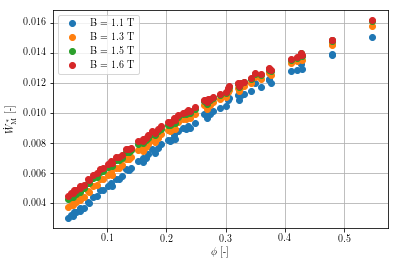

In [27]:
plt.plot(Pi_6[0:72],Pi_10[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_10[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_10[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_10[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{W}_\mathrm{M}^*$ [-]')
plt.legend()
plt.show()

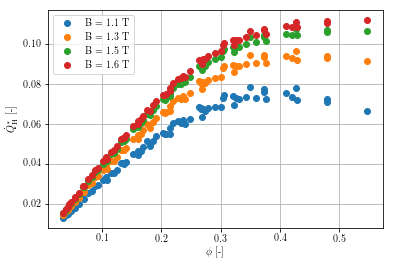

In [28]:
plt.plot(Pi_6[0:72],Pi_9[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_9[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_9[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_9[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{Q}_\mathrm{H}^*$ [-]')
plt.legend()
plt.show()

In [29]:
a = 0*72
b = 4*72

In [30]:
Coef_Wm = curve_fit(fitting_W,(Pi_6[a:b],Pi_4[a:b]),Pi_10[a:b],maxfev=10000)
Coef_Wm

(array([ 1.85012325e-03,  5.75123981e-01, -1.10499621e+01,  1.57263317e-07,
        -2.36039012e+00]),
 array([[ 3.87577581e-08,  4.48498378e-08,  9.27514527e-05,
          6.29378809e-13,  9.99196077e-07],
        [ 4.48498378e-08,  3.85086670e-05, -8.11031449e-05,
          1.81533317e-09,  3.15612136e-03],
        [ 9.27514527e-05, -8.11031449e-05,  2.22964344e-01,
         -6.33240688e-09, -1.11758768e-02],
        [ 6.29378809e-13,  1.81533317e-09, -6.33240688e-09,
          1.54043677e-13,  2.74427797e-07],
        [ 9.99196077e-07,  3.15612136e-03, -1.11758768e-02,
          2.74427797e-07,  4.90156729e-01]]))

NameError: name 'Coef' is not defined

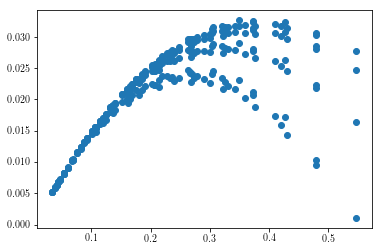

In [31]:
plt.plot(Pi_6[a:b],Pi_8[a:b],'o')
plt.plot(Pi_6[a:b],fitting((Pi_6[a:b],Pi_4[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'o')

In [ ]:
plt.plot(Pi_6[a:b],Pi_9[a:b],'o')
plt.plot(Pi_6[a:b],fitting((Pi_6[a:b],Pi_4[a:b]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'o')

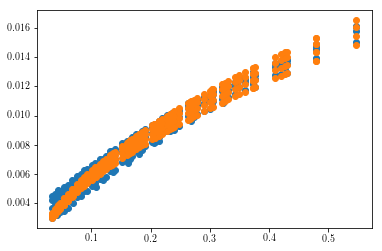

In [32]:
plt.plot(Pi_6[a:b],Pi_10[a:b],'o')
plt.plot(Pi_6[a:b],fitting_W((Pi_6[a:b],Pi_4[a:b]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],0,Coef_Wm[0][4]),'o')

In [33]:
erro1 = abs((Pi_8 - fitting((Pi_6[a:b],Pi_4[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]))/Pi_8*100)
erro2 = abs((Pi_9 - fitting((Pi_6[a:b],Pi_4[a:b]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]))/Pi_9*100)
erro3 = abs((Pi_10 - fitting_W((Pi_6[a:b],Pi_4[a:b]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]))/Pi_10*100)
j=0
h=0
k=0
for i in range(len(erro1)):
    if erro1[i] >= 10:
        j = j+1
    if erro2[i] >= 10:
        h = h+1
    if erro3[i] >= 10:
        k = k+1
j/len(erro1),h/len(erro2),k/len(erro3)

NameError: name 'Coef' is not defined

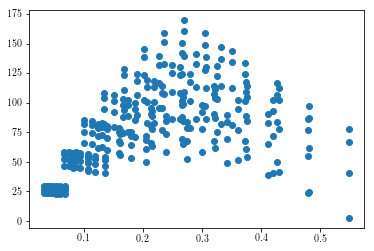

In [34]:
plt.plot(Pi_6,Q_c,'o')

In [35]:
plt.plot(Pi_6,erro1,'o')
plt.ylim([0,25])

NameError: name 'erro1' is not defined

In [36]:
plt.plot(Pi_6,erro1,'o',label = '$\dot{Q}_\mathrm{C}$')
plt.plot(Pi_6,erro2,'o',label = '$\dot{Q}_\mathrm{H}$')
plt.plot(Pi_6,erro3,'o',label = '$\dot{W}_\mathrm{M}$')
plt.ylim(0,30)
plt.xlabel('$\phi$ [-]')
plt.legend()
plt.ylabel('Error [$\%$]')
plt.grid()

NameError: name 'erro1' is not defined

In [37]:
plt.plot(Pi_6,erro3,'o')

NameError: name 'erro3' is not defined

In [38]:
plt.plot(Pi_8,fitting((Pi_6,Pi_7),Coef[0][0],Coef[0][1],Coef[0][2]),'o')
plt.plot(Pi_8,0.9*Pi_8)
plt.plot(Pi_8,1.1*Pi_8)
plt.grid()

NameError: name 'Coef' is not defined

In [ ]:
error_bar = np.arange(0,700)

In [124]:
K = (m_s*f*CdT_dmg)
plt.plot(Pi_8[0:72]*K[0:72],K[0:72]*fitting((Pi_6[0:72],Pi_4[0:72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'o', label = 'B = 1.1 T')
plt.plot(Pi_8[72:2*72]*K[72:2*72],K[72:2*72]*fitting((Pi_6[72:2*72],Pi_4[72:2*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'X', label = 'B = 1.3 T')
plt.plot(Pi_8[2*72:3*72]*K[2*72:3*72],K[2*72:3*72]*fitting((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'s', label = 'B = 1.5 T')
plt.plot(Pi_8[3*72:4*72]*K[3*72:4*72],K[3*72:4*72]*fitting((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.92*error_bar,'k--')
plt.plot(error_bar,1.08*error_bar,'k--')
plt.text(100,80,'- 8\%')
plt.text(80,110,'+ 8\%')


plt.xlabel('Numerical Cooling Capacity [W]')
plt.ylabel('Fitting Cooling Capacity [W]')

plt.grid()
plt.legend()
plt.xlim(0,180)
plt.ylim(0,180)

NameError: name 'm_s' is not defined

In [ ]:
plt.plot((Pi_9*K)[0:72],K[0:72]*fitting((Pi_6[0:72],Pi_4[0:72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'o', label = 'B = 1.1 T')
plt.plot((Pi_9*K)[72:2*72],K[72:144]*fitting((Pi_6[72:2*72],Pi_4[72:2*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'X', label = 'B = 1.3 T')
plt.plot((Pi_9*K)[2*72:3*72],K[144:216]*fitting((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'s', label = 'B = 1.5 T')
plt.plot((Pi_9*K)[3*72:4*72],K[216:288]*fitting((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.9*error_bar,'k--')
plt.plot(error_bar,1.1*error_bar,'k--')
plt.text(300,230,'- 10\%')
plt.text(250,350,'+ 10\%')


plt.xlabel('Numerical Rejected Heat [W]')
plt.ylabel('Fitting Rejected Heat [W]')

plt.grid()
plt.legend()
plt.xlim(20,550)
plt.ylim(20,550)

In [ ]:
plt.plot((Pi_10*K)[0:72],K[0:72]*fitting_W((Pi_6[0:72],Pi_4[0:72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'o', label = 'B = 1.1 T')
plt.plot((Pi_10*K)[72:2*72],K[72:144]*fitting_W((Pi_6[72:2*72],Pi_4[72:2*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'X', label = 'B = 1.3 T')
plt.plot((Pi_10*K)[2*72:3*72],K[144:216]*fitting_W((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'s', label = 'B = 1.5 T')
plt.plot((Pi_10*K)[3*72:4*72],K[216:288]*fitting_W((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.9*error_bar,'k--')
plt.plot(error_bar,1.1*error_bar,'k--')
plt.text(40,31.5,'- 8\%')
plt.text(31.5,45,'+ 8\%')


plt.xlabel('Numerical Magnetic Work[W]')
plt.ylabel('Fitting Magnetic Work [W]')

plt.grid()
plt.legend()
plt.xlim(5,70)
plt.ylim(5,70)